In [1]:
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [2]:
import numpy as np

def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

In [4]:
encoder_input = layers.Input(shape=(32,32,1), name="encoder_input")
x = layers.Conv2D(32, (3,3), strides=2, activation="relu", padding='same')(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation="relu", padding='same')(x)
x = layers.Conv2D(128, (3,3), strides=2, activation="relu", padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name='encoder_output')(x)
encoder = models.Model(encoder_input, encoder_output)

2023-12-27 17:27:54.676041: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-27 17:27:54.676074: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-27 17:27:54.676086: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-27 17:27:54.676156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-27 17:27:54.676405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
decoder_input = layers.Input(shape=(2,), name='decoder_input')
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoder_output = layers.Conv2D(1, (3,3), strides=1, activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = models.Model(decoder_input, decoder_output)

In [6]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

In [7]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
autoencoder.fit(x_train, x_train, epochs=5, batch_size=100,shuffle=True, validation_data=(x_test, x_test),)

Epoch 1/5


2023-12-27 17:27:55.943411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - 19s 26ms/step - loss: 0.2935 - val_loss: 0.2601
Epoch 2/5
600/600 [==============================] - 15s 26ms/step - loss: 0.2565 - val_loss: 0.2563
Epoch 3/5
600/600 [==============================] - 16s 26ms/step - loss: 0.2532 - val_loss: 0.2538
Epoch 4/5
600/600 [==============================] - 15s 26ms/step - loss: 0.2514 - val_loss: 0.2524
Epoch 5/5
600/600 [==============================] - 16s 26ms/step - loss: 0.2502 - val_loss: 0.2519


In [9]:
example_imgs = x_test[:5000]
preds = autoencoder.predict(example_imgs)

157/157 [==============================] - 2s 11ms/step


In [10]:
embeddings = encoder.predict(example_imgs)

import matplotlib.pyplot as plt

157/157 [==============================] - 1s 2ms/step


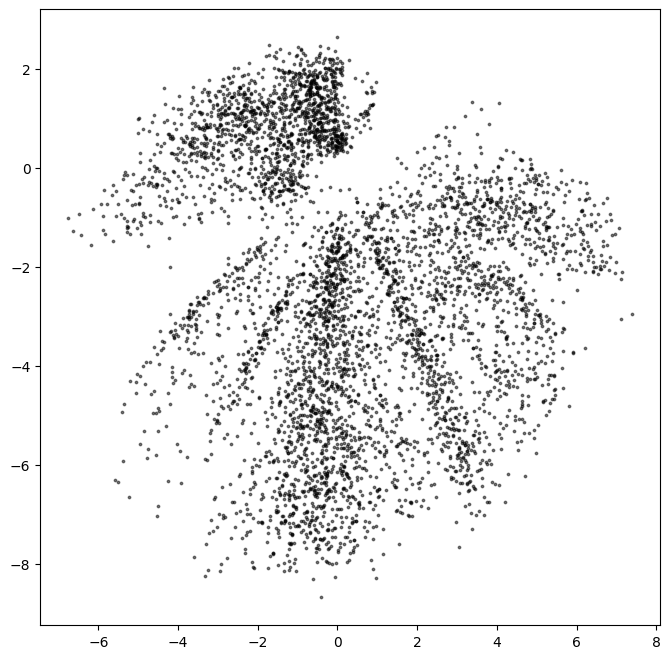

In [11]:
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c='black', alpha=0.5, s=3)
plt.show()

In [12]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxs, size=(18,2))
recon = decoder.predict(sample)

1/1 [==============================] - 0s 141ms/step


### VAE

In [13]:
import tensorflow as tf

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
encoder_input = layers.Input(shape=(32,32,1), name="encoder_input")
x = layers.Conv2D(32, (3,3), strides=2, activation="relu", padding='same')(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation="relu", padding='same')(x)
x = layers.Conv2D(128, (3,3), strides=2, activation="relu", padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name = "z_mean")(x)
z_log_var = layers.Dense(2, name = "z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name = 'encoder')

In [16]:
from vae.model_vae import VAE

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=5, batch_size=100)

Epoch 1/5
600/600 [==============================] - 16s 25ms/step - total_loss: 141.9771 - reconstruction_loss: 136.9007 - kl_loss: 5.0763
Epoch 2/5
600/600 [==============================] - 15s 26ms/step - total_loss: 133.3590 - reconstruction_loss: 128.3069 - kl_loss: 5.0521
Epoch 3/5
600/600 [==============================] - 15s 25ms/step - total_loss: 132.2283 - reconstruction_loss: 127.1303 - kl_loss: 5.0979
Epoch 4/5
600/600 [==============================] - 16s 26ms/step - total_loss: 131.5225 - reconstruction_loss: 126.3595 - kl_loss: 5.1630
Epoch 5/5
600/600 [==============================] - 15s 26ms/step - total_loss: 131.0546 - reconstruction_loss: 125.8313 - kl_loss: 5.2233


157/157 [==============================] - 0s 2ms/step


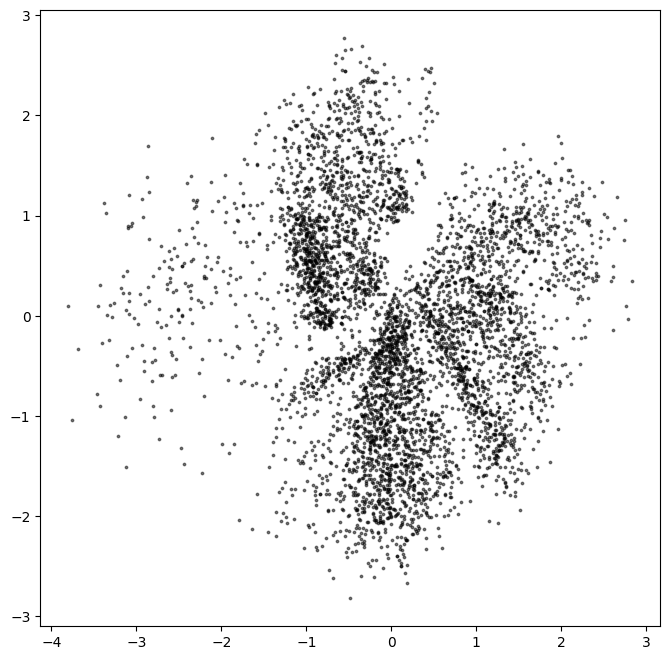

In [19]:
embeddings = encoder.predict(example_imgs)
plt.figure(figsize=(8,8))
embeddings = embeddings[2]
plt.scatter(embeddings[:,0], embeddings[:,1], c='black', alpha=0.5, s=3)
plt.show()